In [1]:
from roofline_utils import *

Autogen version: 0.4.9.1
Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534
SP Balance Point is at: 32.97 flop/byte
DP Balance Point is at: 0.52 flop/byte
INT Balance Point is at: 16.49 intop/byte

These values get passed as LLM context so the model can infer about rooflines:
Peak SP GFLOP/s 25067.52 with FMA
Peak DP GFLOP/s 391.68 with FMA
Peak GINTOP/s 12533.76 with FMA
scraped and pruned CUDA programs count 297
scraped and pruned OMP  programs count 242


### Read in the scraped source codes

### Open the Gathered Data CSV Files

In [2]:

# we need to gather more data for this dataset
df = pd.read_csv('../roofline-data-new.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

print(df.shape)


(2970, 17)


In [3]:
# because a lot of these kernels were sampled twice, let's drop the first sample (which typically runs for longer than the second sample)
#grouped = df.groupby(by=['Kernel Name', 'kernelName', 'targetName', 'exeArgs'])['xtime'].min().reset_index()
grouped = df.groupby(by=['Kernel Name', 'targetName', 'exeArgs'])['xtime'].min().reset_index()

print(grouped.head())
print(grouped.shape)

df = df.merge(grouped, on=list(grouped.columns), how='inner')
# it turns out when we give REGEX to 'ncu' to capture kernels, some kernel names have
# extra characters that also get captured. e.g: AIDW_Kernel and AIDW_Kernel_Tiled both match for the former
# so to deal with this we mainly filter by the 'Kernel Name'  instead of 'kernelName'
#df = df.drop_duplicates(subset=['Kernel Name', 'kernelName', 'targetName', 'exeArgs', 'language'])

counts = df.groupby(['language']).count()
print(counts)
print(df.shape)

                                         Kernel Name           targetName  \
0  AESEncrypt(uchar4 *, const uchar4 *, const uch...             aes-cuda   
1  AIDW_Kernel(const float *, const float *, cons...            aidw-cuda   
2  AIDW_Kernel_Tiled(const float *, const float *...            aidw-cuda   
3  BP_queens_root_dfs(int, unsigned int, int, con...          nqueen-cuda   
4  BezierGPU(const XYZ *, XYZ *, int, int, int, int)  bezier-surface-cuda   

                                             exeArgs        xtime  
0                  100 0 ../urng-sycl/URNG_Input.bmp     549600.0  
1                                           10 1 100    3713056.0  
2                                           10 1 100    2815680.0  
3                                           15 7 100  154966912.0  
4  ../face-cuda/Face.pgm ../face-cuda/info.txt .....    4395488.0  
(1306, 4)
          Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  xtime  Block Size  \
language                              

### Let's drop rows with NULL values and fix exeArgs that got a NaN value because they didn't have exeArgs

These were executions that yielded no performance counter data (i.e: they didn't do single/double precision floating point operations).

In [4]:
df = df[df['Kernel Name'].notna()] 

print(df.shape)

# let's also replace exeArgs that are NaN with ''
df['exeArgs'] = df['exeArgs'].fillna('')

print(df.columns)

(1378, 17)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')


### DROP rows that don't have scraped source code -- the rest of the viz data is on this subset

Search the scraped kernels for their source code -- quantify their token count and add it to the dataframe

In [5]:

enc = tiktoken.encoding_for_model("gpt-4o-mini")

In [6]:
df['numTokens'] = -1
df['numTokensSASS'] = -1
df['kernelCode'] = ''
df['kernelSASS'] = ''

df = df.reset_index(drop=True)

toDrop = []

# for each sample we got, add the scraped code
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    targetName = row['targetName']
    #kernelName = row['Kernel Name']
    # we use the cleaned up kernel names for scraped codes
    kernelName = row['kernelName']
    exeArgs = row['exeArgs']
    language = row['language']
    device = row['device']

    #kernelCode = ''
    include_comments = False
    kernelSASS, kernelCode = get_sass_and_source_from_scraped_codes(targetName, kernelName, include_comments)
    encoded = enc.encode(kernelCode)
    df.iloc[index, df.columns.get_loc('numTokens')] = len(encoded)
    encoded = enc.encode(kernelSASS)
    df.iloc[index, df.columns.get_loc('numTokensSASS')] = len(encoded)
    df.iloc[index, df.columns.get_loc('kernelCode')] = kernelCode
    df.iloc[index, df.columns.get_loc('kernelSASS')] = kernelSASS

    #for elem in scrapedCodes:
    #    basename = elem['basename']
    #    if basename == targetName:
    #        # since all the codes are the same for a target, we grab the first element
    #        kernelCode = list(elem['kernels'].values())[0]
    #        encoded = enc.encode(kernelCode)
    #        df.iloc[index, df.columns.get_loc('numTokens')] = len(encoded)
    #        df.iloc[index, df.columns.get_loc('kernelCode')] = kernelCode
    #        break

    # if a target's kernel code couldn't be found, it's because it's source has too
    # many token, and we had dropped it. Thus, we need to drop the code from our 
    # dataframe
    if kernelCode == '':
        #print(f'Dropping {targetName} -- [{kernelName}]')
        toDrop.append(index)


print(f'Will be dropping {len(toDrop)} rows from the DF -- as we dropped their scraped code for having too many tokens')
print()

print(df.columns)

100%|██████████| 1378/1378 [00:20<00:00, 67.87it/s] 

Will be dropping 451 rows from the DF -- as we dropped their scraped code for having too many tokens

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'numTokensSASS', 'kernelCode', 'kernelSASS'],
      dtype='object')


In [7]:
df = df.drop(index=toDrop, axis=1)

In [8]:
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.head())
print(df.tail())

(927, 21)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'numTokensSASS', 'kernelCode', 'kernelSASS'],
      dtype='object')
Kernel Name      string[python]
traffic                 float64
dpAI                    float64
spAI                    float64
dpPerf                  float64
spPerf                  float64
xtime                   float64
Block Size       string[python]
Grid Size        string[python]
device           string[python]
intops                  float64
intPerf                 float64
intAI                   float64
targetName       string[python]
exeArgs          string[python]
kernelName       string[python]
language                 object
numTokens                 int64
numTokensSASS             int64
kernelCode               object
kernelSASS               object
dtype: object
      

### Check some high-level stats

In [9]:
# how many different kernel invocations did we capture?

totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 433
Total unique kernel executions recorded: 884
Number of kernels with no arithmetic intensity (AI) 388 (43.89%)
Number of non-zero AI single-precision kernels recorded: 453 (51.24%)
Number of non-zero AI double-precision kernels recorded: 100 (11.31%)
Number of non-zero Perf single-precision kernels recorded: 453 (51.24%)
Number of non-zero Perf double-precision kernels recorded: 100 (11.31%)
Number of non-zero Perf intop kernels recorded: 884 (100.0%)
Number of non-zero AI intop kernels recorded: 884 (100.0%)


In [10]:

#print(df[df['targetName'] == 'bspline-vgh-cuda'])
#df['exeArgs'] = df['exeArgs'].apply(lambda x: '' if x == 'NULL' else x )

#print(df.dtypes)


### Scale the Performance Data

Here we scale down the `spPerf` and `dpPerf` columns to be on the scale of 1e11 (like how it's done in `ncu`).

In [11]:
# scale everything to be in TFLOP/s
df['dpPerf'] = df['dpPerf']*(1e-12)
df['spPerf'] = df['spPerf']*(1e-12)
df['intPerf'] = df['intPerf']*(1e-12)


### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

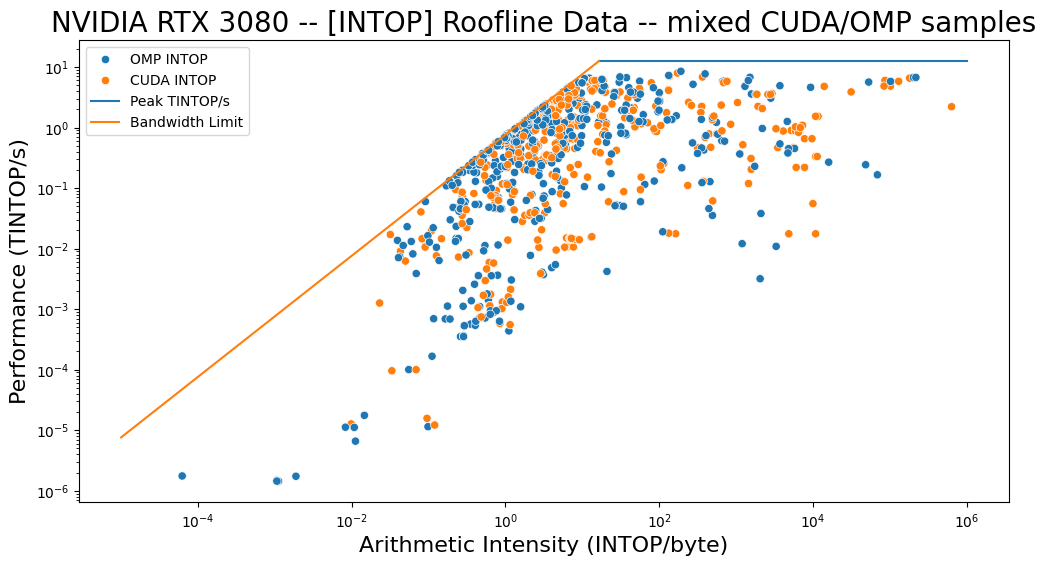

In [12]:
# it should be noted that samples with AI=0 and Perf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', hue='language', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)

# plot the intOPS roofline line
ax.plot([intOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e6], [intOPMaxPerfTFLOP,intOPMaxPerfTFLOP], label='Peak SP TFLOP/s')

# plot the roofline slanted line
ax.plot([1e-5, intOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,intOPMaxPerfTFLOP], label='Max Bandwidth')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(f'{gpuName} -- [INTOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TINTOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = ['OMP INTOP', 'CUDA INTOP', 'Peak TINTOP/s', 'Bandwidth Limit']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

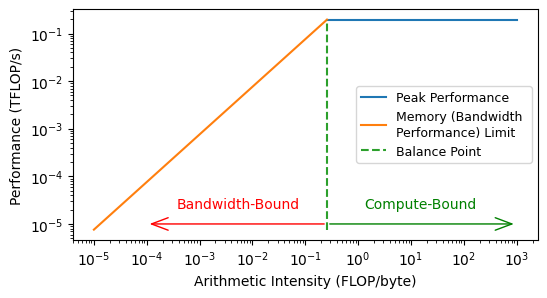

Max Bandwidth TB/s 0.7603
Peak Performance shown TFLOP/s: 0.19584


In [13]:
import matplotlib.patches as mpatches

# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(6,3))

# plot the SPOPS roofline line
#ax.plot([spOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [spOPMaxPerfTFLOP,spOPMaxPerfTFLOP], label='Peak SP TFLOP/s (with FMA)')

#ax.plot([spOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [spOPMaxPerfTFLOP/2,spOPMaxPerfTFLOP/2], label='Peak SP TFLOP/s (no FMA)')
#
## plot the DPOPS roofline line
#ax.plot([dpOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [dpOPMaxPerfTFLOP,dpOPMaxPerfTFLOP], label='Peak DP TFLOP/s (with FMA)')
#

balancePoint = dpOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec)

ax.plot([balancePoint, 1e3], [dpOPMaxPerfTFLOP/2,dpOPMaxPerfTFLOP/2], label='Peak DP TFLOP/s (no FMA)')
#
## plot the roofline slanted line
ax.plot([1e-5, balancePoint], [maxBandwidthTBPerSec*1e-5,dpOPMaxPerfTFLOP/2], label='Max Bandwidth')

# plot the balance point line
ax.plot([balancePoint, balancePoint], [maxBandwidthTBPerSec*1e-5,dpOPMaxPerfTFLOP/2], label='Balance Point', linestyle='--')

#sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

#ax.set_title(f'{gpuName} -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)
#ax.set_title(f'Example Roofline Model', fontsize=16)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=10)
ax.set_ylabel('Performance (TFLOP/s)', fontsize=10)

legend = ax.legend()
#legend.labels = [ 'SP Peak Perf. (with FMA)', 'SP Peak Perf. (no FMA)', 'DP Peak Perf. (with FMA)', 'DP Peak Perf. (no FMA)', 'Bandwidth Limit', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP']
legend.labels = [ 'Peak Performance', 'Memory (Bandwidth \nPerformance) Limit', 'Balance Point']
ax.legend(legend.legend_handles, legend.labels, fontsize=9)

arr = mpatches.FancyArrowPatch((balancePoint, 1e-5), (1e3, 1e-5),
                               arrowstyle='->,head_width=.15', mutation_scale=30, color='green')
ax.add_patch(arr)
ax.annotate("Compute-Bound", (0.5, 1.5), xycoords=arr, ha='center', va='bottom', color='green')

arr = mpatches.FancyArrowPatch((balancePoint, 1e-5), (1e-4, 1e-5),
                               arrowstyle='->,head_width=.15', mutation_scale=30, color='red')
ax.add_patch(arr)
ax.annotate("Bandwidth-Bound", (0.5, 1.5), xycoords=arr, ha='center', va='bottom', color='red')

plt.show()

print('Max Bandwidth TB/s', maxBandwidthTBPerSec)
print('Peak Performance shown TFLOP/s:', dpOPMaxPerfTFLOP_noFMA )

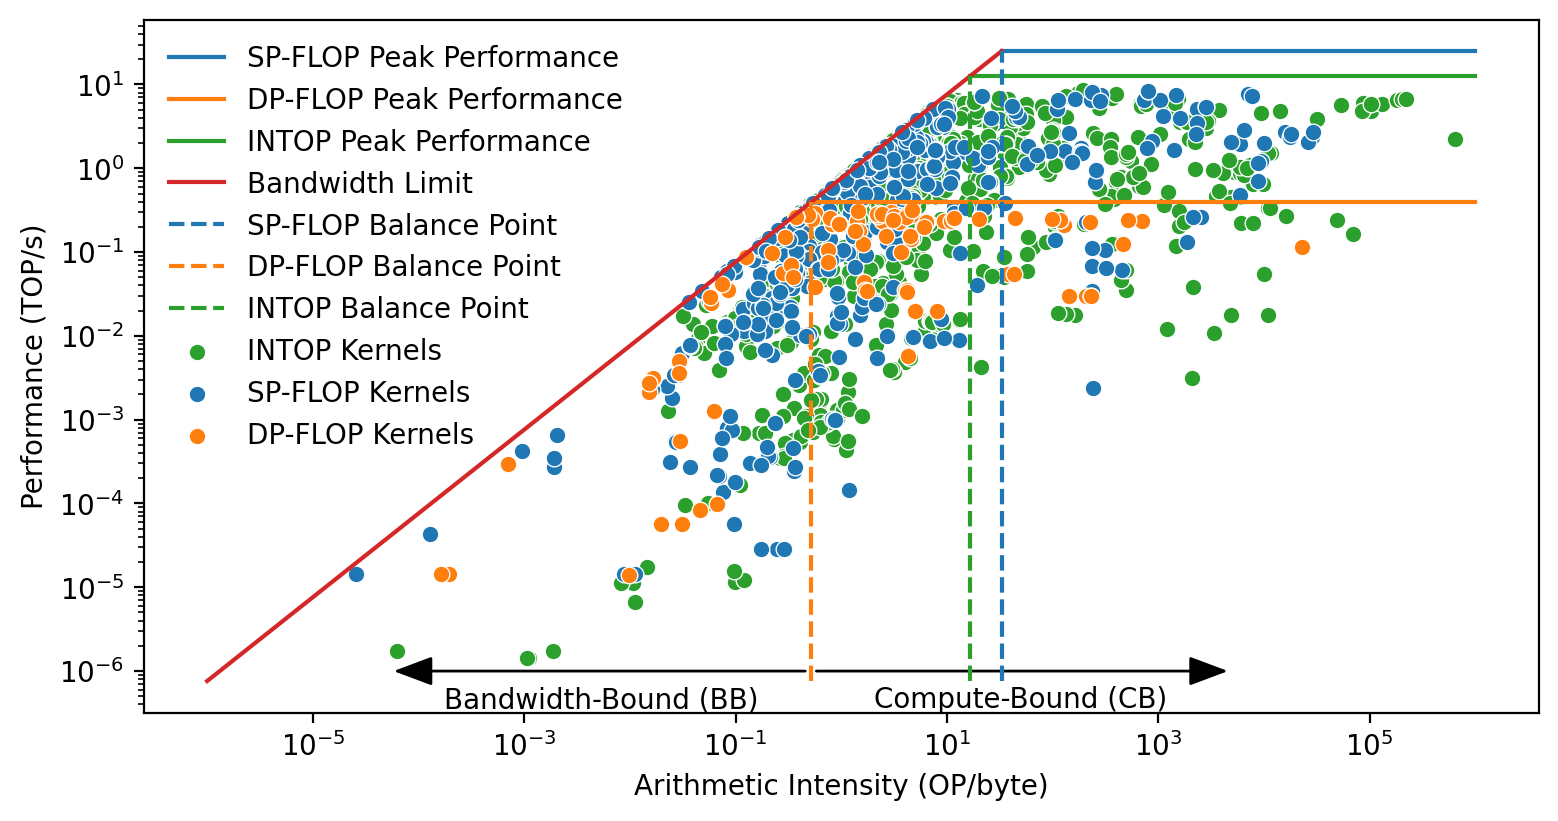

In [14]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(9,4.5), dpi=200)

bottom = 1e-6
rightside = 1e6

# plot the SPOPS roofline line
ax.plot([spOPMaxPerfTFLOP/maxBandwidthTBPerSec, rightside], [spOPMaxPerfTFLOP,spOPMaxPerfTFLOP], label='Peak SP TFLOP/s (with FMA)')

# leave out the NON-FMA rooflines -- they overcomplicate the plot
#ax.plot([spOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [spOPMaxPerfTFLOP/2,spOPMaxPerfTFLOP/2], label='Peak SP TFLOP/s (no FMA)')

# plot the DPOPS roofline line
ax.plot([dpOPMaxPerfTFLOP/maxBandwidthTBPerSec, rightside], [dpOPMaxPerfTFLOP,dpOPMaxPerfTFLOP], label='Peak DP TFLOP/s (with FMA)')

# leave out the NON-FMA rooflines -- they overcomplicate the plot
#ax.plot([dpOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [dpOPMaxPerfTFLOP/2,dpOPMaxPerfTFLOP/2], label='Peak DP TFLOP/s (no FMA)')

ax.plot([intOPMaxPerfTFLOP/maxBandwidthTBPerSec, rightside], [intOPMaxPerfTFLOP,intOPMaxPerfTFLOP], label='Peak SP TFLOP/s')

# plot the roofline slanted line
ax.plot([bottom, spOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*bottom,spOPMaxPerfTFLOP], label='Max Bandwidth')

ax.plot([balancePointSPFLOPPerByte, balancePointSPFLOPPerByte], [maxBandwidthTBPerSec*bottom,spOPMaxPerfTFLOP], label='Balance Point', linestyle='--', color='C0')
ax.plot([balancePointDPFLOPPerByte, balancePointDPFLOPPerByte], [maxBandwidthTBPerSec*bottom,dpOPMaxPerfTFLOP], label='Balance Point', linestyle='--', color='C1')
ax.plot([balancePointINTOPPerByte, balancePointINTOPPerByte], [maxBandwidthTBPerSec*bottom,intOPMaxPerfTFLOP], label='Balance Point', linestyle='--', color='C2')

#sns.scatterplot(df, x='intAI', y='intPerf', ax=ax, style='language')
#sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')

sns.scatterplot(df, x='intAI', y='intPerf', ax=ax, color='C2', label='INT')
sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, color='C0', label='SP')
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, color='C1', label='DP')


ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

#ax.set_title(f'{gpuName} -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)
#ax.set_title(f'{gpuName} -- [FLOP] Roofline Data', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (OP/byte)', fontsize=10)
ax.set_ylabel('Performance (TOP/s)', fontsize=10)

legend = ax.legend()
#legend.labels = [ 'SP Peak Perf. (with FMA)', 'SP Peak Perf. (no FMA)', 'DP Peak Perf. (with FMA)', 'DP Peak Perf. (no FMA)', 'Bandwidth Limit', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP', 'SP-FLOP Balance Point', 'DP-FLOP Balance Point']
#legend.labels = [ 'SP Peak Perf. (with FMA)', 'DP Peak Perf. (with FMA)', 'Bandwidth Limit', 'SP-FLOP Balance Point', 'DP-FLOP Balance Point', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP']
legend.labels = [ 'SP-FLOP Peak Performance', 'DP-FLOP Peak Performance', 'INTOP Peak Performance', 'Bandwidth Limit', 'SP-FLOP Balance Point', 'DP-FLOP Balance Point', 'INTOP Balance Point', 'INTOP Kernels', 'SP-FLOP Kernels', 'DP-FLOP Kernels']
ax.legend(legend.legend_handles, legend.labels, framealpha=0.0)

arr = mpatches.FancyArrowPatch((balancePointDPFLOPPerByte, 1e-6), (balancePointDPFLOPPerByte*1e4, 1e-6),
                               arrowstyle='-|>,head_width=.15', mutation_scale=30, color='black')
ax.add_patch(arr)
ax.annotate("Compute-Bound (CB)", (0.5, -1.2), xycoords=arr, ha='center', va='bottom', color='black')

arr = mpatches.FancyArrowPatch((balancePointDPFLOPPerByte, 1e-6), (balancePointDPFLOPPerByte*1e-4, 1e-6),
                               arrowstyle='-|>,head_width=.15', mutation_scale=30, color='black')
ax.add_patch(arr)
ax.annotate("Bandwidth-Bound (BB)", (0.5, -1.2), xycoords=arr, ha='center', va='bottom', color='black')

plt.show()

Notice how the NVIDIA-reported roofline looks very similar to our rooflines!

Their DP roofline is just under 10e11 FLOP/s (so is ours!) 
Their SP roofline is just above 100e11 FLOP/s -- ours is actually just under 100e11.

We essenitally just performed an empirical roofline gathering! 

### Note
The NVIDIA rooflines are based on empirical data that they seem to gather on-the-fly, as the rooflines seem to change slightly across ncu reports.

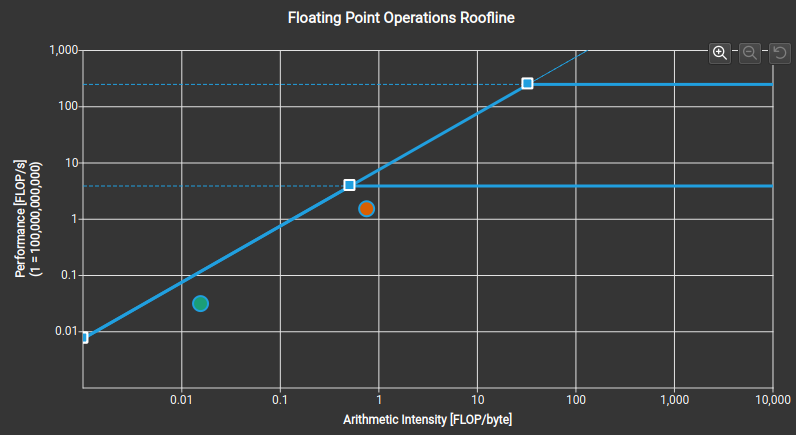

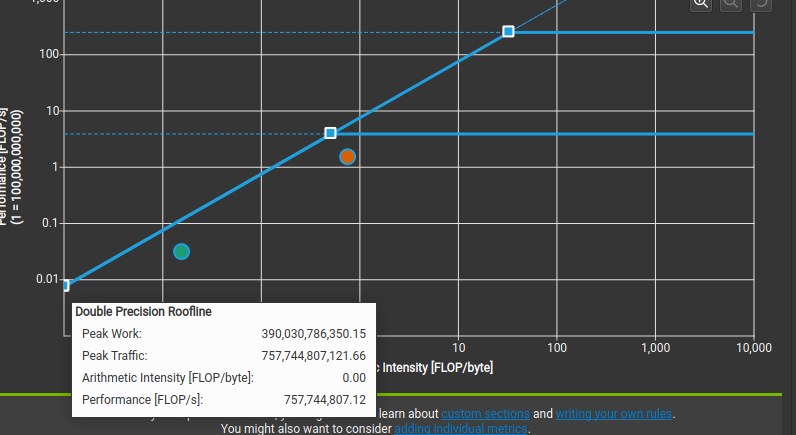

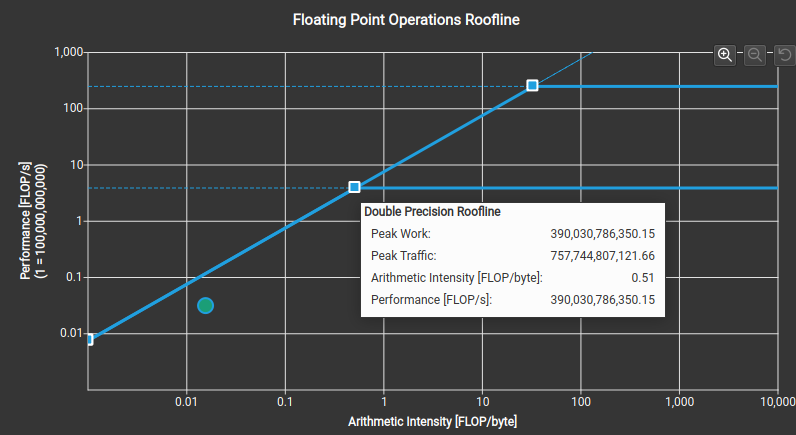

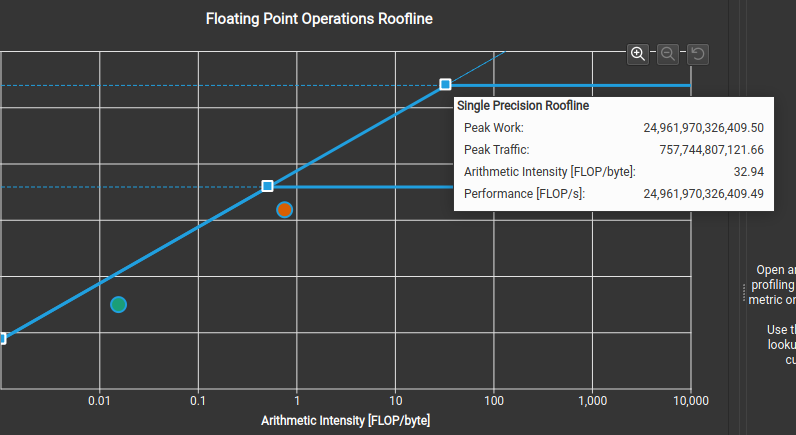

### Check the distribution of arithmetic intensity

### Let's add a column as a bandwidth-bound indicator

In [15]:
# This is only classifying a code as Bandwidth-Bound because of its Single-Precision behavior
# Sometimes the SP is really low because a code is doing DP ops, so it may not be BB
#df['isBB'] = df['spAI'] < balancePointSPFLOPPerByte

# We instead opt to check if the code is BB relative to all 3 metrics (intOP, spFLOP, dpFLOP)
# where each metric is checked against its respective balance point.
# If the LLM is smart enough, it should recognize the types of operations a code is doing and then
# be able to classify which roofline it belongs to.
df['isBB'] = (df['spAI'] < balancePointSPFLOPPerByte) & (df['dpAI'] < balancePointDPFLOPPerByte) & (df['intAI'] < balancePointINTOPPerByte)

df['isBB'] = df['isBB'].apply(lambda x: 1 if x else 0)

df['class'] = df['isBB'].apply(lambda x: 'Bandwidth-Bound' if x==1 else 'Compute-Bound')
df['answer'] = df['isBB'].apply(lambda x: 'Bandwidth' if x==1 else 'Compute')

In [16]:
print(df.head())

                                         Kernel Name       traffic      dpAI  \
0  haccmk_kernel(int, int, const float *, const f...  7.156462e+07  0.000000   
1  bit_rev_permutation(long *, const long *, unsi...  4.585366e+09  0.000000   
2  bit_rev_permutation_z(long *, const long *, un...  6.496454e+09  0.000000   
3  initial_value(unsigned int, double, double, do...  2.528404e+10  9.317279   
4  solve(unsigned int, double, double, double, do...  5.187426e+11  0.563661   

          spAI    dpPerf    spPerf      xtime    Block Size      Grid Size  \
0  1868.406255  0.000000  0.133712  2990528.0   (256, 1, 1)      (4, 1, 1)   
1     0.000000  0.000000  0.000000     3936.0  (1024, 1, 1)      (1, 1, 1)   
2     0.000000  0.000000  0.000000     4512.0    (32, 1, 1)      (2, 1, 1)   
3     0.409507  0.235578  0.010354  6480864.0   (256, 1, 1)  (65536, 1, 1)   
4     0.000000  0.292395  0.000000   516416.0   (256, 1, 1)  (65536, 1, 1)   

                    device  ...    exeArgs        

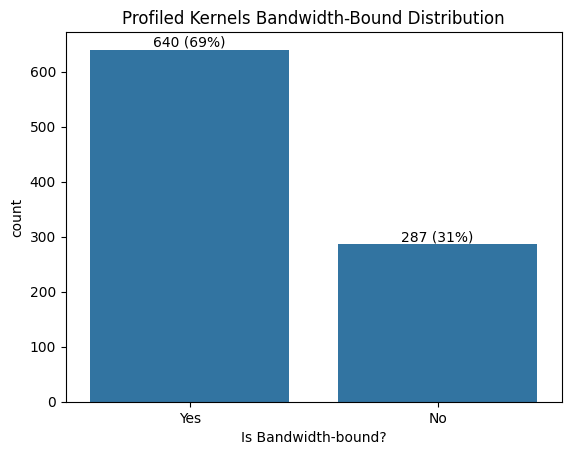

In [17]:
# let's plot the distribution

ax = sns.countplot(data=df, order=df['isBB'].value_counts(ascending=False).index, x='isBB')

abs_values = df['isBB'].value_counts(ascending=False)
rel_values = df['isBB'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('Profiled Kernels Bandwidth-Bound Distribution')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()

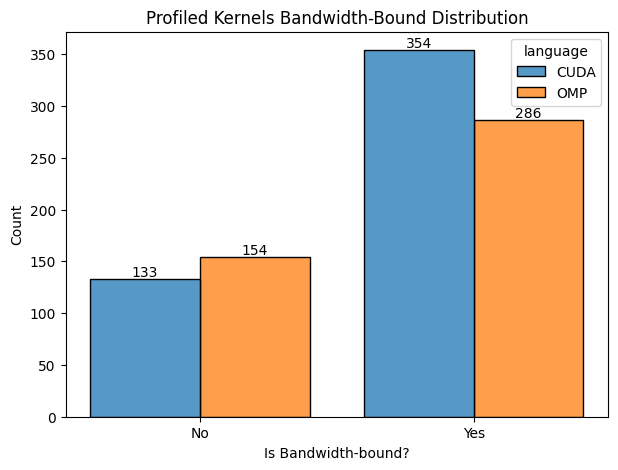

In [18]:
# plot the distribution of OMP and CUDA codes that are BB and CB
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

y = sns.histplot(data=df, x='isBB', hue='language', multiple='dodge', discrete=True, ax=ax, shrink=0.8)


for cont in y.containers:
    labels = [str(v) if v else '' for v in cont.datavalues]
    y.bar_label(cont, labels=labels)

ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('Profiled Kernels Bandwidth-Bound Distribution')

plt.show()

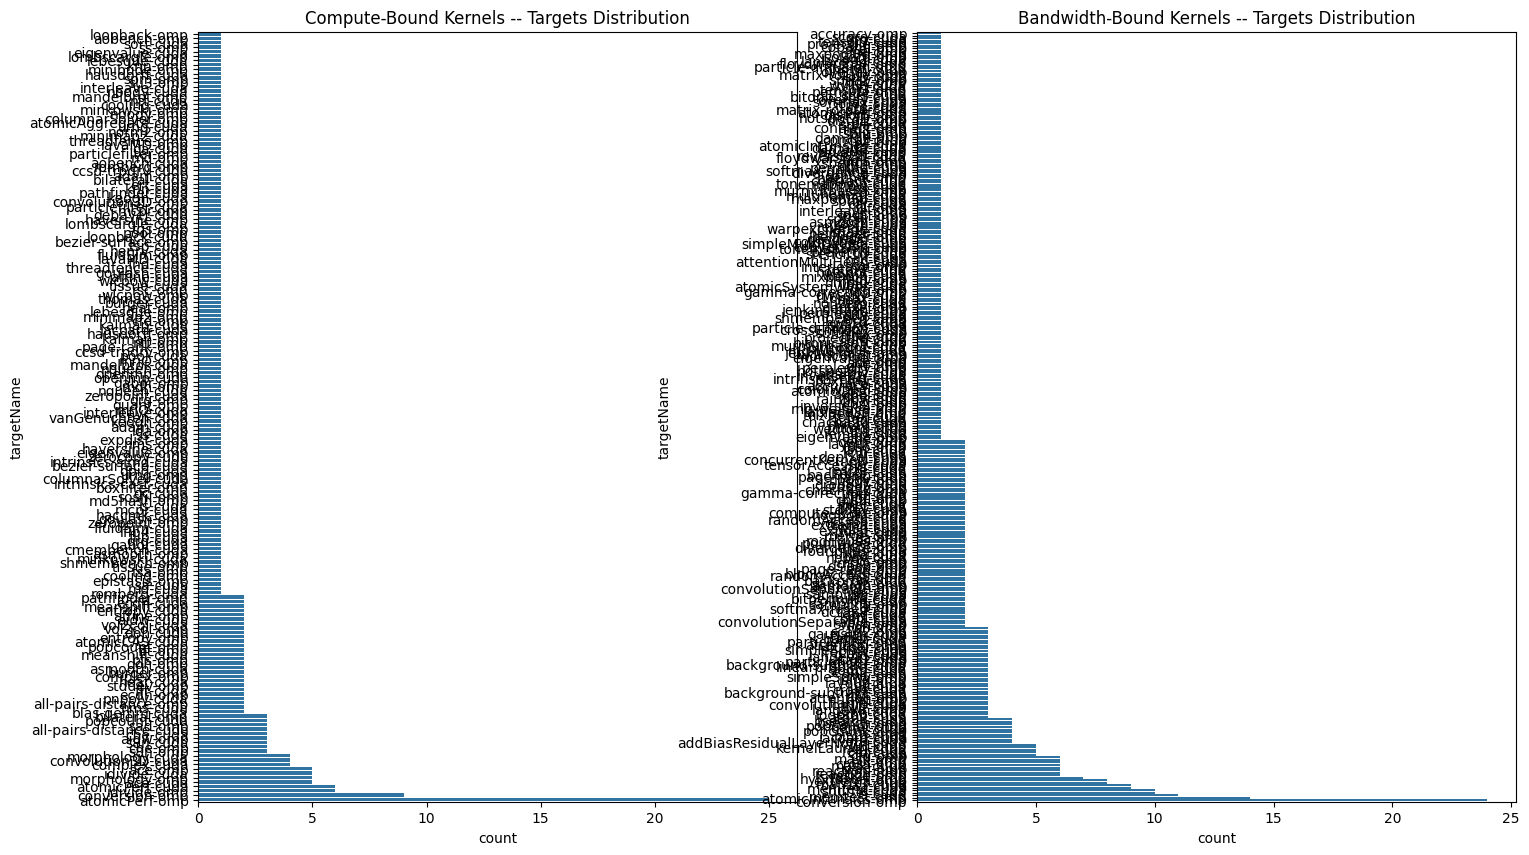

In [19]:
# now let's check how many kernels that are NOT BB come from the same program

cbKernels = df[df['isBB'] == 0].copy()
bbKernels = df[df['isBB'] == 1].copy()

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

sns.countplot(data=cbKernels, order=cbKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[0])
sns.countplot(data=bbKernels, order=bbKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[1])

axs[0].set_title('Compute-Bound Kernels -- Targets Distribution')
axs[1].set_title('Bandwidth-Bound Kernels -- Targets Distribution')

plt.show()

In [20]:
# let's check if there's any overlap in targetNames from the datasets


common = set(cbKernels['targetName']) & set(bbKernels['targetName'])

print(common)
print()
print(f'The Compute-Bound (CB) and Bandwidth-Bound (BB) subsets have {len(common)} executables in common')
print()

print('Number of kernels for each common executable')

cbCounts = cbKernels.groupby(['targetName'])['Kernel Name'].count().reset_index().sort_values(by=['targetName'])
bbCounts = bbKernels.groupby(['targetName'])['Kernel Name'].count().reset_index().sort_values(by=['targetName'])

cbCounts = cbCounts[cbCounts['targetName'].isin(common)]
bbCounts = bbCounts[bbCounts['targetName'].isin(common)]

cbCounts.set_index('targetName', inplace=True)
bbCounts.set_index('targetName', inplace=True)

allCounts = pd.DataFrame(index=cbCounts.index)

allCounts['cbCounts'] = cbCounts['Kernel Name']
allCounts['bbCounts'] = bbCounts['Kernel Name']

print(allCounts.sort_values(by=['bbCounts', 'cbCounts'], ascending=False))



{'che-cuda', 'burger-omp', 'ace-omp', 'dpid-cuda', 'atomicPerf-omp', 'popcount-cuda', 'knn-cuda', 'qrg-omp', 'heat-omp', 'asmooth-omp', 'jaccard-cuda', 'che-omp', 'ace-cuda', 'knn-omp', 'heat-cuda', 'cfd-omp', 'asmooth-cuda', 'particlefilter-omp', 'intrinsics-cast-cuda', 'sa-cuda', 'nbody-omp', 'page-rank-omp', 'conversion-omp', 'eigenvalue-omp', 'burger-cuda', 'mcpr-cuda', 'interleave-cuda', 'interleave-omp', 'nms-omp', 'boxfilter-omp', 'sort-cuda', 'qrg-cuda', 'lfib4-cuda', 'tsa-omp', 'gc-cuda', 'expdist-cuda', 'nbody-cuda', 'stddev-omp', 'is-cuda', 'sosfil-omp', 'mriQ-cuda', 'eigenvalue-cuda', 'mriQ-omp', 'particlefilter-cuda', 'popcount-omp', 'mcpr-omp'}

The Compute-Bound (CB) and Bandwidth-Bound (BB) subsets have 46 executables in common

Number of kernels for each common executable
                      cbCounts  bbCounts
targetName                              
conversion-omp               9        24
is-cuda                      1        10
sa-cuda                      1      

### Visualize the token count distribution

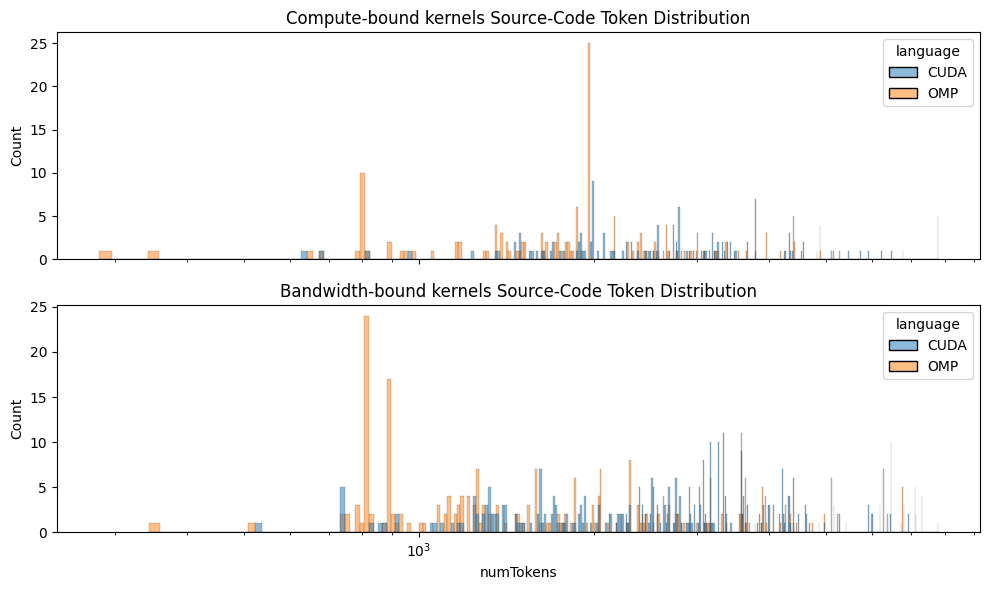

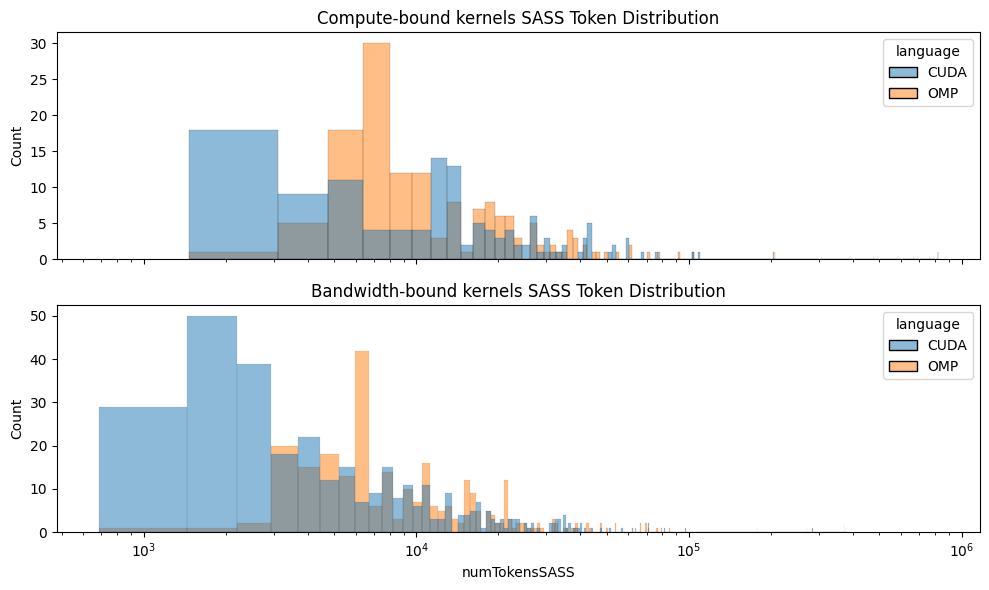

In [21]:

#fig = px.histogram(df[df['isBB'] == 0], x="numTokens", color="language", marginal='rug', nbins=500, title='Compute-bound kernels Token Distribution')
#fig.show()
#fig = px.histogram(df[df['isBB'] == 1], x="numTokens", color="language", marginal='rug', nbins=500, title='Bandwidth-bound kernels Token Distribution')
#fig.show()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Compute-bound kernels Token Distribution
sns.histplot(data=df[df['isBB'] == 0], x="numTokens", hue="language", kde=False, bins=500, ax=axes[0])
axes[0].set_title('Compute-bound kernels Source-Code Token Distribution')

# Bandwidth-bound kernels Token Distribution
sns.histplot(data=df[df['isBB'] == 1], x="numTokens", hue="language", kde=False, bins=500, ax=axes[1])
axes[1].set_title('Bandwidth-bound kernels Source-Code Token Distribution')

axes[0].set_xscale('log')
axes[1].set_xscale('log')

# Adjust layout
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

sns.histplot(data=df[df['isBB'] == 0], x="numTokensSASS", hue="language", kde=False, bins=500, ax=axes[0])
axes[0].set_title('Compute-bound kernels SASS Token Distribution')
sns.histplot(data=df[df['isBB'] == 1], x="numTokensSASS", hue="language", kde=False, bins=500, ax=axes[1])
axes[1].set_title('Bandwidth-bound kernels SASS Token Distribution')

axes[0].set_xscale('log')
axes[1].set_xscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

### Target deduplication

Because each kernel of each target is mapped to the same source code, we don't want to have multiple kernels of one target of the same boundedness class in the training/testing datasets, as our model might over-train on the similar repeat data.

In [22]:
# now we want to pick at most 1 sample of a targetName from the CB and BB set
# this is because although we may pick 2 different kernels, they map to the same code
# so 

print(df.columns)

# we indiscriminately pick the samples with the smallest token counts in each group
singleSubset = df.loc[df.groupby(['targetName', 'exeArgs', 'isBB', 'language', 'device']).numTokens.idxmin()]

print(singleSubset.columns)

singleSubset = singleSubset.reset_index(drop=True)

print(singleSubset.columns)

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'numTokensSASS', 'kernelCode', 'kernelSASS', 'isBB', 'class', 'answer'],
      dtype='object')
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'numTokensSASS', 'kernelCode', 'kernelSASS', 'isBB', 'class', 'answer'],
      dtype='object')
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'numTokensSASS', 'kernelCode', 'kernelSASS', 'isBB', 'class', 'answer'],
      dtype='object')


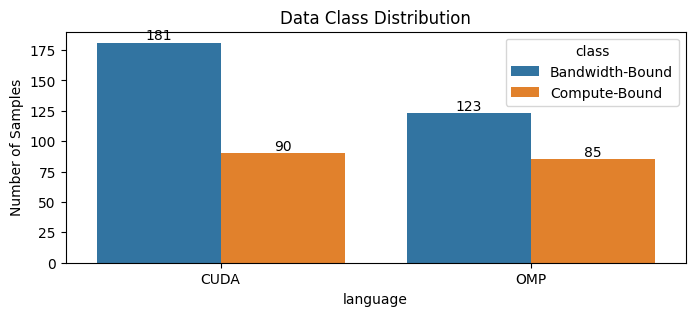

In [23]:
trainToPlot = singleSubset.groupby(['language', 'class']).count().reset_index()

fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.barplot(data=trainToPlot, x='language', y='Kernel Name', hue='class', ax = ax)
ax.set_title('Data Class Distribution')
ax.set_ylabel('Number of Samples')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

Number of sampled executables 433


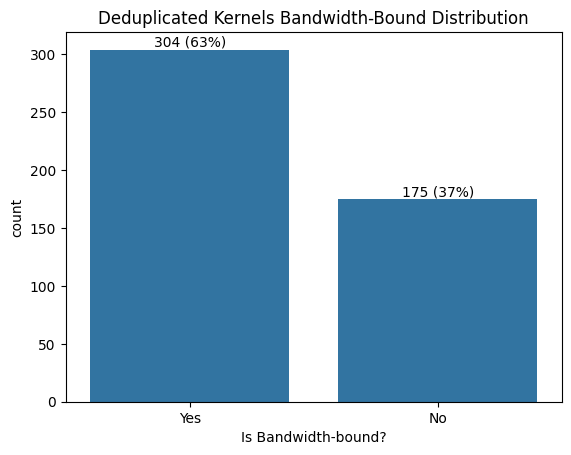

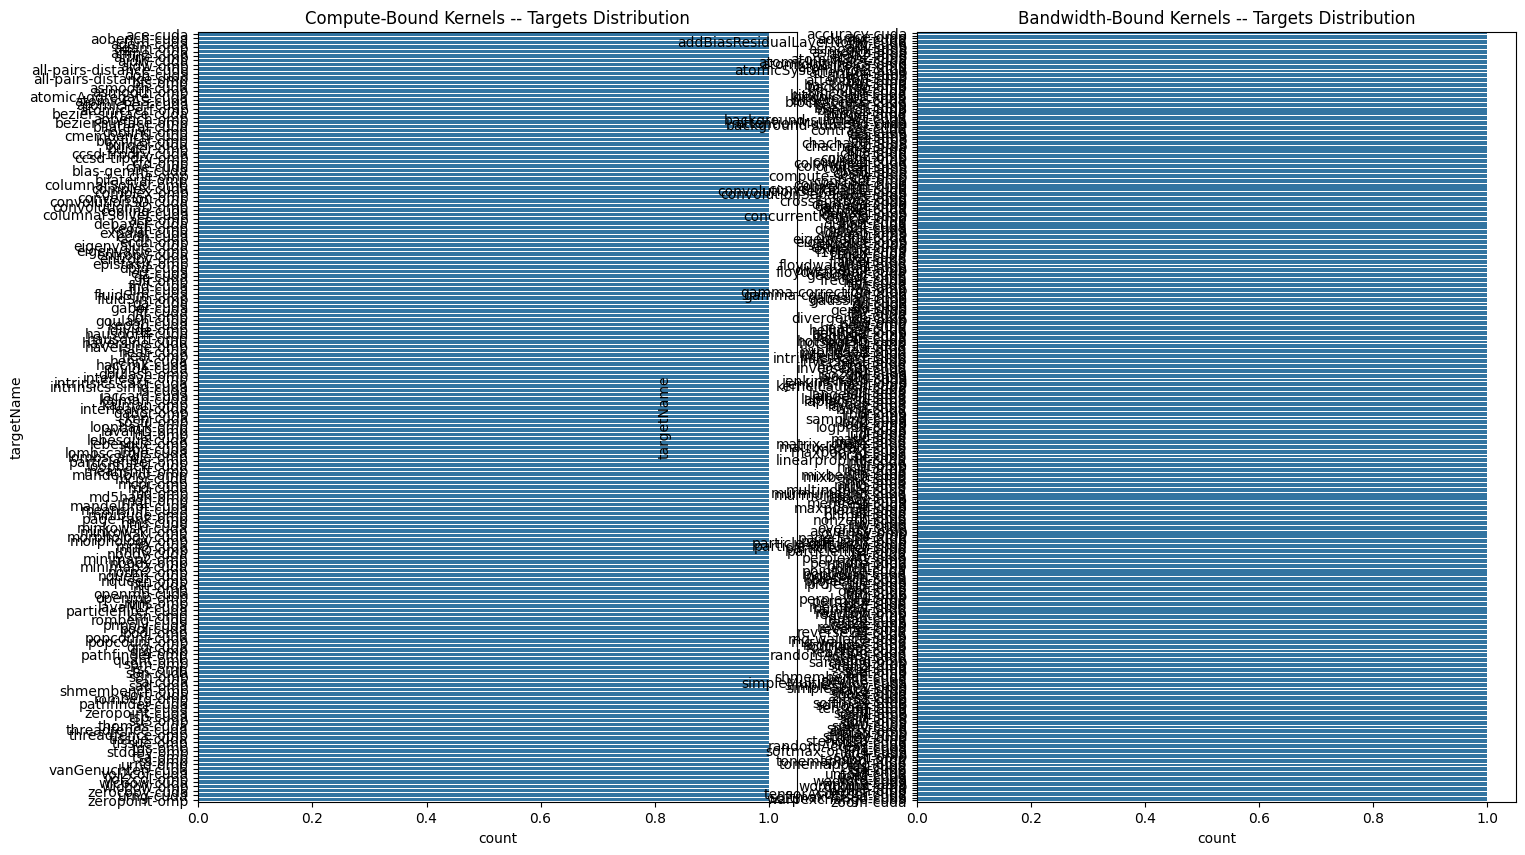

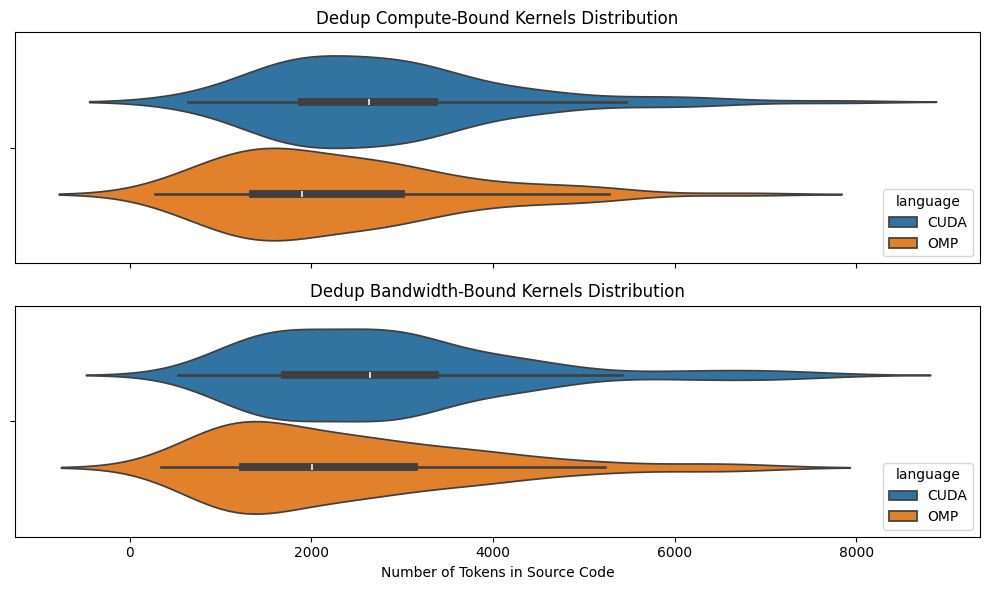

In [24]:
print('Number of sampled executables', df.groupby(['targetName']).ngroups)

ax = sns.countplot(data=singleSubset, order=singleSubset['isBB'].value_counts(ascending=False).index, x='isBB')

abs_values = singleSubset['isBB'].value_counts(ascending=False)
rel_values = singleSubset['isBB'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('Deduplicated Kernels Bandwidth-Bound Distribution')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()


subsetCBKernels = singleSubset[singleSubset['isBB'] == 0]
subsetBBKernels = singleSubset[singleSubset['isBB'] == 1]

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

sns.countplot(data=subsetCBKernels, order=subsetCBKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[0])
sns.countplot(data=subsetBBKernels, order=subsetBBKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[1])

axs[0].set_title('Compute-Bound Kernels -- Targets Distribution')
axs[1].set_title('Bandwidth-Bound Kernels -- Targets Distribution')

plt.show()



# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Dedup Compute-Bound Kernels Distribution
sns.violinplot(data=subsetCBKernels, x="numTokens", hue="language",  ax=axes[0]) #kde=False, bins=1000,
axes[0].set_title('Dedup Compute-Bound Kernels Distribution')
axes[0].set_xlabel('Number of Tokens in Source Code')

# Dedup Bandwidth-Bound Kernels Distribution
sns.violinplot(data=subsetBBKernels, x="numTokens", hue="language",  ax=axes[1]) #kde=False, bins=1000,
axes[1].set_title('Dedup Bandwidth-Bound Kernels Distribution')
axes[1].set_xlabel('Number of Tokens in Source Code')

# Adjust layout
plt.tight_layout()
plt.show()


In [25]:
def balance_dataframe(df, random_seed=4839):
    # Group the dataframe by the columns we want to balance by
    grouped = df.groupby(['class', 'language'])
    
    # Find the minimum number of rows among all groups
    min_size = grouped.size().min()
    
    # Sample min_size rows from each group and reset the index
    balanced_df = grouped[df.columns].apply(lambda x: x.sample(min_size, random_state=random_seed)).reset_index(drop=True)
    
    return balanced_df


In [26]:
# create the training test split

def split_balanced_data(balanced_df, random_seed=4839):
    # Create a stratification column combining 'a' and 'b'
    stratify_col = balanced_df['class'].astype(str) + '_' + balanced_df['language'].astype(str)
    
    # Split into training and validation sets with stratification
    train_df, val_df = train_test_split(
        balanced_df,
        test_size=0.2,
        random_state=random_seed,
        stratify=stratify_col
    )
    
    return train_df, val_df

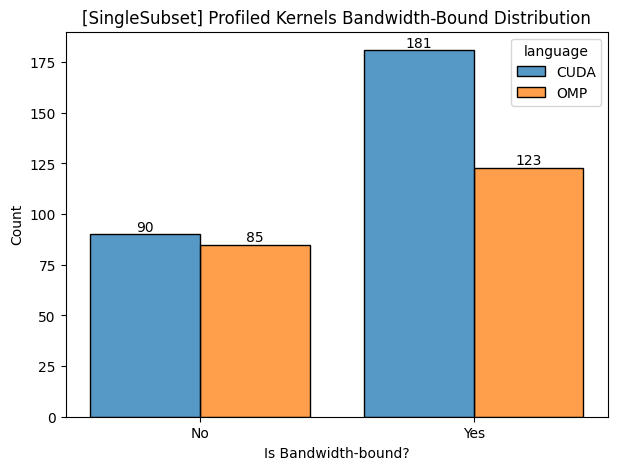

In [27]:

# plot the distribution of OMP and CUDA codes that are BB and CB
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

y = sns.histplot(data=singleSubset, x='isBB', hue='language', multiple='dodge', discrete=True, ax=ax, shrink=0.8)


for cont in y.containers:
    labels = [str(v) if v else '' for v in cont.datavalues]
    y.bar_label(cont, labels=labels)

ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('[SingleSubset] Profiled Kernels Bandwidth-Bound Distribution')

plt.show()

### Plot the Arithmetic Intensity Distribution of the balanced datasets

## Create a training-test split

### Check the distribution of the training + test data


Technically it's balanced in terms of CB and BB samples, but not in Grid/Block Size

In [28]:

balanced_df = balance_dataframe(singleSubset)
trainDF, valDF = split_balanced_data(balanced_df, random_seed=4839)

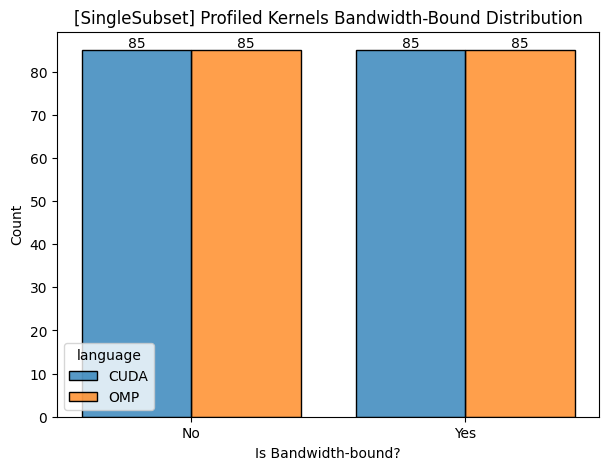

In [29]:

# plot the distribution of OMP and CUDA codes that are BB and CB
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

y = sns.histplot(data=balanced_df, x='isBB', hue='language', multiple='dodge', discrete=True, ax=ax, shrink=0.8)


for cont in y.containers:
    labels = [str(v) if v else '' for v in cont.datavalues]
    y.bar_label(cont, labels=labels)

ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('[SingleSubset] Profiled Kernels Bandwidth-Bound Distribution')

plt.show()

In [30]:
checkDF = balanced_df.copy()
checkDF['isSPBB'] = (checkDF['spAI'] < balancePointSPFLOPPerByte)
checkDF['isDPBB'] = (checkDF['dpAI'] < balancePointDPFLOPPerByte)
checkDF['isIntBB'] = (checkDF['intAI'] < balancePointINTOPPerByte)

checkDF['bbSummary'] = list(zip(checkDF['isSPBB'], checkDF['isDPBB'], checkDF['isIntBB']))

print('only considering CUDA for check')
checkDF = checkDF[checkDF['language'] == 'CUDA']

# what this tells us is that most of out codes are Bandwidth-Bound for all 3 data types
# this means they are very clearly bandwidth-bound. In the other cases though, we have
# a large majority of codes that are BB at the SP and DP levels, but not at the intop
# level. These may be codes that do the major portion of their work as integer operations.
print('(isSPBB, isDPBB, isIntBB)')
checkDFCounts = checkDF.groupby(['bbSummary'])['kernelName'].count()
print(checkDFCounts)

targetNamesToCheck = ['meanshift-cuda', 'ss-cuda', 'atomicCAS-cuda', 'perplexity-cuda', 'all-pairs-distance-cuda', 'particlefilter-cuda', 'md-cuda', 'keogh-cuda', 'rodrigues-cuda', 'threadfence-cuda', 'mcpr-cuda', 'libor-cuda', 'zerocopy-cuda', 'sort-cuda', 'gc-cuda', 'doh-cuda', 'affine-cuda', 'tsa-cuda', 'lfib4-cuda', 'convolution3D-cuda', 'thomas-cuda', 'ccsd-trpdrv-cuda', 'particlefilter-cuda', 'hausdorff-cuda', 'ace-cuda', 'morphology-cuda', 'qrg-cuda', 'debayer-cuda', 'pathfinder-cuda', 'vol2col-cuda', 'flame-cuda', 'sosfil-cuda', 'minkowski-cuda', 'snake-cuda', 'lebesgue-cuda', 'che-cuda', 'jaccard-cuda', 'tissue-cuda', 'fluidSim-cuda', 'nms-cuda', 'blas-gemm-cuda', 'colorwheel-cuda', 'knn-cuda', 'atomicAggregate-cuda', 'rng-wallace-cuda', 'tqs-cuda', 'collision-cuda', 'cmembench-cuda', 'geodesic-cuda', 'lfib4-cuda', 'entropy-cuda', 'zeropoint-cuda', 'urng-cuda', 'pool-cuda', 'burger-cuda', 'sa-cuda', 's8n-cuda', 'bilateral-cuda', 'mixbench-cuda', 'asmooth-cuda']

# check particular mispredicted cases
mispredCases = checkDF[(checkDF['targetName'].isin(targetNamesToCheck))].reset_index(drop=True)
mispredCases = mispredCases.sort_values(by=['bbSummary']).reset_index(drop=True)

# we can note that the majority of the mispredicted cases occur when the codes
# are ONLY BB for the double+single precision flop operations
mispredCounts = mispredCases.groupby(['bbSummary'])['kernelName'].count()
print(mispredCounts)
print(100 * mispredCounts / checkDFCounts)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(mispredCases[['targetName', 'bbSummary', 'kernelName', 'spAI', 'dpAI', 'intAI', 'isBB']])

only considering CUDA for check
(isSPBB, isDPBB, isIntBB)
bbSummary
(False, False, False)     1
(False, True, False)     24
(False, True, True)       2
(True, False, False)      5
(True, False, True)      16
(True, True, False)      37
(True, True, True)       85
Name: kernelName, dtype: int64
bbSummary
(False, True, False)     8
(False, True, True)      1
(True, False, False)     1
(True, False, True)      8
(True, True, False)     27
(True, True, True)      21
Name: kernelName, dtype: int64
bbSummary
(False, False, False)          NaN
(False, True, False)     33.333333
(False, True, True)      50.000000
(True, False, False)     20.000000
(True, False, True)      50.000000
(True, True, False)      72.972973
(True, True, True)       24.705882
Name: kernelName, dtype: float64
                 targetName             bbSummary  \
0                  knn-cuda  (False, True, False)   
1                keogh-cuda  (False, True, False)   
2            meanshift-cuda  (False, True, False)   
3 

             class language  Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  \
0  Bandwidth-Bound     CUDA           68       68    68    68      68      68   
1  Bandwidth-Bound      OMP           68       68    68    68      68      68   
2    Compute-Bound     CUDA           68       68    68    68      68      68   
3    Compute-Bound      OMP           68       68    68    68      68      68   

   xtime  Block Size  ...  intAI  targetName  exeArgs  kernelName  numTokens  \
0     68          68  ...     68          68       68          68         68   
1     68          68  ...     68          68       68          68         68   
2     68          68  ...     68          68       68          68         68   
3     68          68  ...     68          68       68          68         68   

   numTokensSASS  kernelCode  kernelSASS  isBB  answer  
0             68          68          68    68      68  
1             68          68          68    68      68  
2             68      

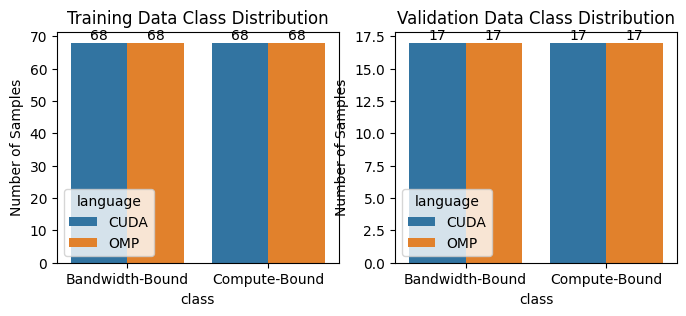

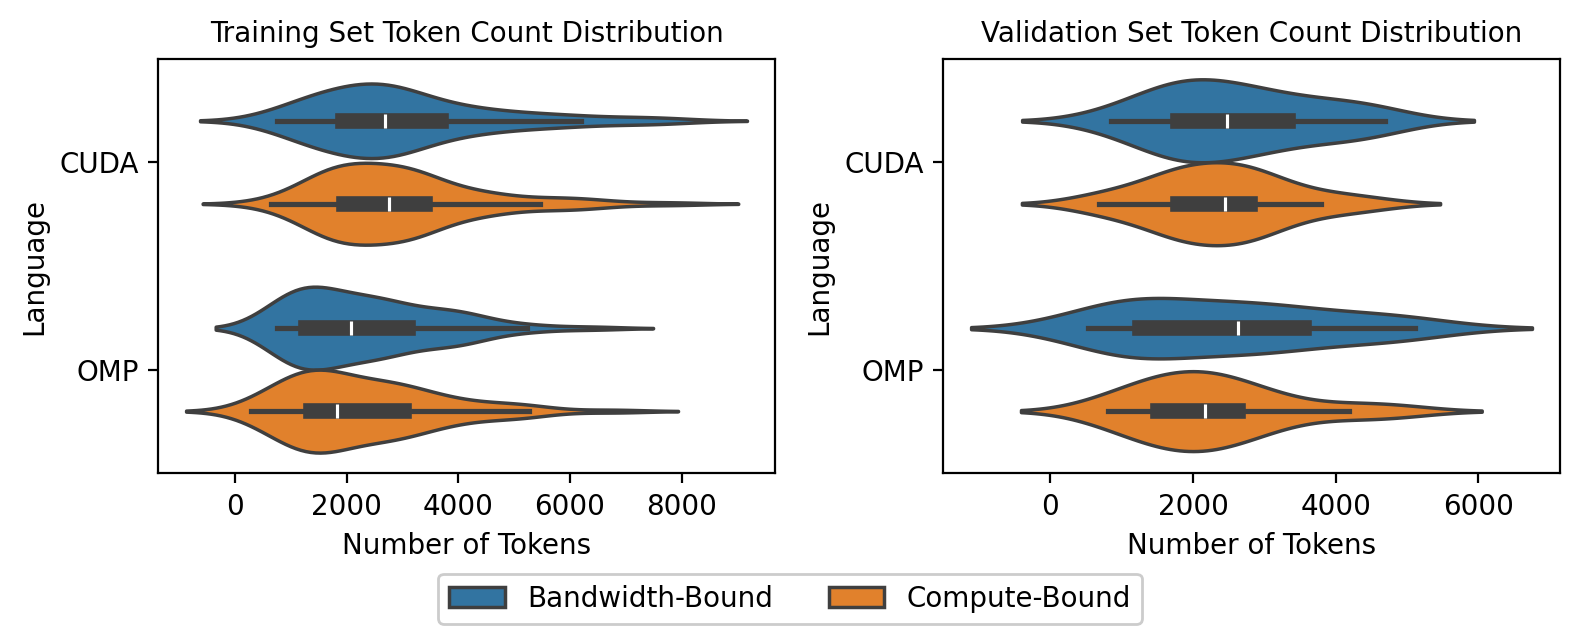

In [31]:
# These should show an even number of compute-bound and bandwidth-bound samples in each dataset

trainToPlot = trainDF.groupby(['class', 'language']).count().reset_index()
print(trainToPlot)
valToPlot = valDF.groupby(['class', 'language']).count().reset_index()


fig, axs = plt.subplots(1,2, figsize=(8,3))
sns.barplot(data=trainToPlot, x='class', y='Kernel Name', hue='language', ax = axs[0])
sns.barplot(data=valToPlot, x='class', y='Kernel Name', hue='language', ax = axs[1])
axs[0].set_title('Training Data Class Distribution')
axs[0].set_ylabel('Number of Samples')
axs[1].set_title('Validation Data Class Distribution')
axs[1].set_ylabel('Number of Samples')

for ax in axs:
    for i in ax.containers:
        ax.bar_label(i,)

plt.show()


fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=200)
sns.violinplot(trainDF, x="numTokens", y='language', hue="class", inner='box', ax=axs[0], legend=False)
axs[0].set_title('Training Set Token Count Distribution', fontsize=10)
axs[0].set_xlabel('Number of Tokens')
axs[0].set_ylabel('Language')

sns.violinplot(valDF, x="numTokens", y='language', hue="class", inner='box', ax=axs[1])
axs[1].set_title('Validation Set Token Count Distribution', fontsize=10)
axs[1].set_xlabel('Number of Tokens')
axs[1].set_ylabel('Language')

#axs[0].get_legend().remove()
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='', bbox_to_anchor=(0,0,1.0,0.05), framealpha=1.0, ncols=2)

axs[1].get_legend().remove()

fig.tight_layout()
plt.show()

## Check the language distribution

  language            class  Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  \
0     CUDA  Bandwidth-Bound           68       68    68    68      68      68   
1     CUDA    Compute-Bound           68       68    68    68      68      68   
2      OMP  Bandwidth-Bound           68       68    68    68      68      68   
3      OMP    Compute-Bound           68       68    68    68      68      68   

   xtime  Block Size  ...  intAI  targetName  exeArgs  kernelName  numTokens  \
0     68          68  ...     68          68       68          68         68   
1     68          68  ...     68          68       68          68         68   
2     68          68  ...     68          68       68          68         68   
3     68          68  ...     68          68       68          68         68   

   numTokensSASS  kernelCode  kernelSASS  isBB  answer  
0             68          68          68    68      68  
1             68          68          68    68      68  
2             68      

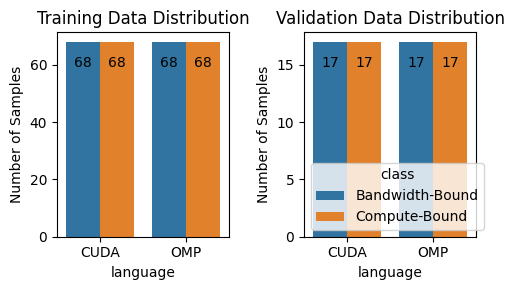

In [32]:
trainToPlot = trainDF.groupby(['language', 'class']).count().reset_index()
print(trainToPlot)
valToPlot = valDF.groupby(['language', 'class']).count().reset_index()


fig, axs = plt.subplots(1,2, figsize=(5,3))
sns.barplot(data=trainToPlot, x='language', y='Kernel Name', hue='class', ax = axs[0], legend=False)
sns.barplot(data=valToPlot, x='language', y='Kernel Name', hue='class', ax = axs[1])
axs[0].set_title('Training Data Distribution')
axs[0].set_ylabel('Number of Samples')
axs[1].set_title('Validation Data Distribution')
axs[1].set_ylabel('Number of Samples')

for ax in axs:
    for i in ax.containers:
        ax.bar_label(i,padding=-20)

# Shrink current axis's height by 10% on the bottom
#box = ax.get_position()
#ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                 box.width, box.height * 0.9])

# Put a legend below current axis
#axs[1].legend(loc='upper right', bbox_to_anchor=(0.5, -0.05),
#          fancybox=True, shadow=True, ncol=5)

#fig.tight_layout(pad=1.08, rect=[0, 0, 1, 0.85])
fig.tight_layout()


plt.show()

### Write out a file for training and another for testing, also write out all the samples for zero-shot inference

#### Writing to files

In [33]:
print(trainDF.columns)
print(trainDF.head())

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'numTokensSASS', 'kernelCode', 'kernelSASS', 'isBB', 'class', 'answer'],
      dtype='object')
                                           Kernel Name       traffic  dpAI  \
76   void resize<unsigned char, 8>(T1 *, unsigned l...  6.166348e+11   0.0   
220                 mean_shift(const float *, float *)  8.017931e+07   0.0   
239  StringSearchLoadBalance(const unsigned char *,...  1.912679e+09   0.0   
123  __omp_offloading_10309_2fc54ad__Z13motion_devi...  4.215229e+11   0.0   
273  __omp_offloading_10309_2fc55e6__Z16KernelPool2...  6.923409e+10   0.0   

            spAI  dpPerf    spPerf       xtime   Block Size      Grid Size  \
76      0.146057     0.0  0.090064    186304.0  (256, 1, 1)  (29184, 1, 1)   
220  8749.694403     0.0  0.701544   1756064.0   (

In [ ]:
train_root = 'train-dataset-balanced-no-comments'
val_root = 'validation-dataset-balanced-no-comments'

#train_root = 'train-dataset-balanced'
#val_root = 'validation-dataset-balanced'

trainDF.to_csv(f'{train_root}.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 
valDF.to_csv(f'{val_root}.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 



In [ ]:
trainOMPOnly = trainDF[trainDF['language'] == 'OMP']
valOMPOnly= valDF[valDF['language'] == 'OMP']

trainCUDAOnly = trainDF[trainDF['language'] == 'CUDA']
valCUDAOnly= valDF[valDF['language'] == 'CUDA']

trainOMPOnly.to_csv(f'{train_root}-OMP-only.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 
valOMPOnly.to_csv(f'{val_root}-OMP-only.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 

trainCUDAOnly.to_csv(f'{train_root}-CUDA-only.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 
valCUDAOnly.to_csv(f'{val_root}-CUDA-only.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 

In [ ]:
await write_df_to_jsonl(trainDF, f'{train_root}', 1, True)
await write_df_to_jsonl(valDF, f'{val_root}', 1, True)


In [ ]:
await write_df_to_jsonl(trainOMPOnly, f'{train_root}-OMP-only', 2, True)
await write_df_to_jsonl(valOMPOnly, f'{val_root}-OMP-only', 2, True)

await write_df_to_jsonl(trainCUDAOnly, f'{train_root}-CUDA-only', 3, True)
await write_df_to_jsonl(valCUDAOnly, f'{val_root}-CUDA-only', 3, True)

In [35]:
# check that the no-comments dataset has the same samples as the with-comments dataset

trainDF_with_comments = pd.read_csv('train-dataset-balanced.csv', quotechar='"', dtype=dtypes)
trainDF_wo_comments = pd.read_csv('train-dataset-balanced-no-comments.csv', quotechar='"', dtype=dtypes)

wComments = set(sorted(list(trainDF_with_comments['targetName'].unique())))
woComments = set(sorted(list(trainDF_wo_comments['targetName'].unique())))

assert wComments == woComments, 'The datasets do not match!'


validationDF_with_comments = pd.read_csv('validation-dataset-balanced.csv', quotechar='"', dtype=dtypes)
validationDF_wo_comments = pd.read_csv('validation-dataset-balanced-no-comments.csv', quotechar='"', dtype=dtypes)

wComments = set(sorted(list(validationDF_with_comments['targetName'].unique())))
woComments = set(sorted(list(validationDF_wo_comments['targetName'].unique())))

assert wComments == woComments, 'The datasets do not match!'


